In [ ]:
import pystac_client # access STAC catalogs
import planetary_computer # sign items
import dask.dataframe as dd

# ----- accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)


# ----- access items in gbif catalog
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
#list(items)


# ---- select and sign first item
item = list(items.values())[0]
#print(item)

signed_asset = planetary_computer.sign(item).assets["data"]


# ---- read data frame using parquet, specify columns
df = dd.read_parquet(
    signed_asset.href,
    columns=["species",
            #"countrycode",
            "stateprovince",
            "decimallatitude",
            "decimallongitude",
            #"coordinateuncertaintyinmeters",
            #"day",
            #"month",
            "year",
            "institutioncode"],
    storage_options=signed_asset.extra_fields["table:storage_options"],  #???
)
#df

# ---- select first chunk
chunk = df.get_partition(0).compute()
#print(type(chunk))
#chunk

In [18]:
import pandas as pd
import geopandas

def clip_chunk(chunk , shapefile):
    
    ca_sightings = chunk.loc[chunk['stateprovince'] == 'California'].filter(items=['species',
                                                                                   'decimallatitude',
                                                                                   'decimallongitude'])
    # add: if none, then return
    # add: remove species == None
    
    gdf = geopandas.GeoDataFrame(ca_sightings, 
                                 geometry = geopandas.points_from_xy(x=ca_sightings.decimallongitude, y=ca_sightings.decimallatitude)
                                )
    gdf = gdf.set_crs(4326)
    gdf = gdf.to_crs(shapefile.crs)
    
    return geopandas.clip(gdf,shapefile)

In [15]:
# ---- OPEN SB shapefile ----

sb_shape_path = "/home/jovyan/Sedgwick_Reserve/SB_geometry/SB_only.shp"
sb_shape = gpd.read_file(sb_shape_path)
#print(sb_shape.crs)
#sb_shape.plot(edgecolor='purple', color='yellow')


In [19]:
sb_chunk0 = clip_chunk(chunk, sb_shape)

<AxesSubplot:>

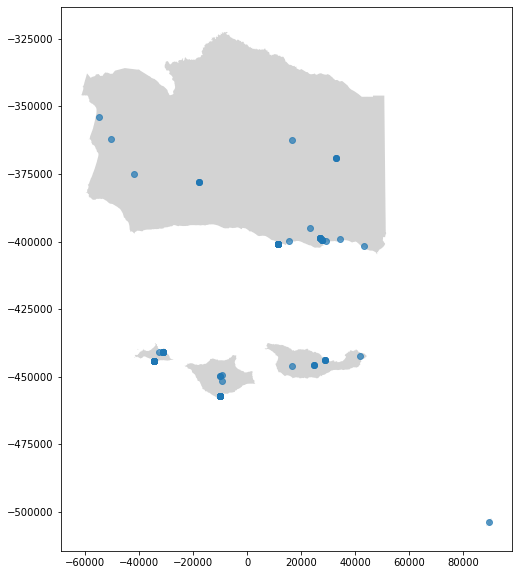

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
sb_shape.plot(ax=ax, color='lightgrey')
sb_chunk0.plot(ax=ax, alpha=0.7)


# TO DO: 
Rewrite this flow to work directly on dask DataFrame so it can be parallelized.